# PolyQ Rotamers Analysis  - L4_Q12_DES-amber

### Libraries of interest 

In [28]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sns
import pandas as pd
import mdtraj as md
import scipy.stats as st
import nglview as nv
import MDAnalysis as mda
from nglview.datafiles import PDB,XTC
from scipy.spatial.distance import cdist
%matplotlib inline
import os
import matplotlib.pyplot as plt
from matplotlib import cm
#from scipy.stats import gaussian_kde
from Bio.SeqUtils import IUPACData
from __future__ import print_function
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import itertools
import mdtraj.testing
from itertools import product

### Kernel density estimation

In [29]:
class gaussian_kde(object):
    """Representation of a kernel-density estimate using Gaussian kernels.

    Kernel density estimation is a way to estimate the probability density
    function (PDF) of a random variable in a non-parametric way.
    `gaussian_kde` works for both uni-variate and multi-variate data.   It
    includes automatic bandwidth determination.  The estimation works best for
    a unimodal distribution; bimodal or multi-modal distributions tend to be
    oversmoothed.

    Parameters
    ----------
    dataset : array_like
        Datapoints to estimate from. In case of univariate data this is a 1-D
        array, otherwise a 2-D array with shape (# of dims, # of data).
    bw_method : str, scalar or callable, optional
        The method used to calculate the estimator bandwidth.  This can be
        'scott', 'silverman', a scalar constant or a callable.  If a scalar,
        this will be used directly as `kde.factor`.  If a callable, it should
        take a `gaussian_kde` instance as only parameter and return a scalar.
        If None (default), 'scott' is used.  See Notes for more details.
    weights : array_like, shape (n, ), optional, default: None
        An array of weights, of the same shape as `x`.  Each value in `x`
        only contributes its associated weight towards the bin count
        (instead of 1).

    Attributes
    ----------
    dataset : ndarray
        The dataset with which `gaussian_kde` was initialized.
    d : int
        Number of dimensions.
    n : int
        Number of datapoints.
    neff : float
        Effective sample size using Kish's approximation.
    factor : float
        The bandwidth factor, obtained from `kde.covariance_factor`, with which
        the covariance matrix is multiplied.
    covariance : ndarray
        The covariance matrix of `dataset`, scaled by the calculated bandwidth
        (`kde.factor`).
    inv_cov : ndarray
        The inverse of `covariance`.

    Methods
    -------
    kde.evaluate(points) : ndarray
        Evaluate the estimated pdf on a provided set of points.
    kde(points) : ndarray
        Same as kde.evaluate(points)
    kde.pdf(points) : ndarray
        Alias for ``kde.evaluate(points)``.
    kde.set_bandwidth(bw_method='scott') : None
        Computes the bandwidth, i.e. the coefficient that multiplies the data
        covariance matrix to obtain the kernel covariance matrix.
        .. versionadded:: 0.11.0
    kde.covariance_factor : float
        Computes the coefficient (`kde.factor`) that multiplies the data
        covariance matrix to obtain the kernel covariance matrix.
        The default is `scotts_factor`.  A subclass can overwrite this method
        to provide a different method, or set it through a call to
        `kde.set_bandwidth`.

    Notes
    -----
    Bandwidth selection strongly influences the estimate obtained from the KDE
    (much more so than the actual shape of the kernel).  Bandwidth selection
    can be done by a "rule of thumb", by cross-validation, by "plug-in
    methods" or by other means; see [3]_, [4]_ for reviews.  `gaussian_kde`
    uses a rule of thumb, the default is Scott's Rule.

    Scott's Rule [1]_, implemented as `scotts_factor`, is::

        n**(-1./(d+4)),

    with ``n`` the number of data points and ``d`` the number of dimensions.
    Silverman's Rule [2]_, implemented as `silverman_factor`, is::

        (n * (d + 2) / 4.)**(-1. / (d + 4)).

    Good general descriptions of kernel density estimation can be found in [1]_
    and [2]_, the mathematics for this multi-dimensional implementation can be
    found in [1]_.

    References
    ----------
    .. [1] D.W. Scott, "Multivariate Density Estimation: Theory, Practice, and
           Visualization", John Wiley & Sons, New York, Chicester, 1992.
    .. [2] B.W. Silverman, "Density Estimation for Statistics and Data
           Analysis", Vol. 26, Monographs on Statistics and Applied Probability,
           Chapman and Hall, London, 1986.
    .. [3] B.A. Turlach, "Bandwidth Selection in Kernel Density Estimation: A
           Review", CORE and Institut de Statistique, Vol. 19, pp. 1-33, 1993.
    .. [4] D.M. Bashtannyk and R.J. Hyndman, "Bandwidth selection for kernel
           conditional density estimation", Computational Statistics & Data
           Analysis, Vol. 36, pp. 279-298, 2001.

    Examples
    --------
    Generate some random two-dimensional data:

    >>> from scipy import stats
    >>> def measure(n):
    >>>     "Measurement model, return two coupled measurements."
    >>>     m1 = np.random.normal(size=n)
    >>>     m2 = np.random.normal(scale=0.5, size=n)
    >>>     return m1+m2, m1-m2

    >>> m1, m2 = measure(2000)
    >>> xmin = m1.min()
    >>> xmax = m1.max()
    >>> ymin = m2.min()
    >>> ymax = m2.max()

    Perform a kernel density estimate on the data:

    >>> X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    >>> positions = np.vstack([X.ravel(), Y.ravel()])
    >>> values = np.vstack([m1, m2])
    >>> kernel = stats.gaussian_kde(values)
    >>> Z = np.reshape(kernel(positions).T, X.shape)

    Plot the results:

    >>> import matplotlib.pyplot as plt
    >>> fig = plt.figure()
    >>> ax = fig.add_subplot(111)
    >>> ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
    ...           extent=[xmin, xmax, ymin, ymax])
    >>> ax.plot(m1, m2, 'k.', markersize=2)
    >>> ax.set_xlim([xmin, xmax])
    >>> ax.set_ylim([ymin, ymax])
    >>> plt.show()

    """
    def __init__(self, dataset, bw_method=None, weights=None):
        self.dataset = np.atleast_2d(dataset)
        if not self.dataset.size > 1:
            raise ValueError("`dataset` input should have multiple elements.")
        self.d, self.n = self.dataset.shape
            
        if weights is not None:
            self.weights = weights / np.sum(weights)
        else:
            self.weights = np.ones(self.n) / self.n
            
        # Compute the effective sample size 
        # http://surveyanalysis.org/wiki/Design_Effects_and_Effective_Sample_Size#Kish.27s_approximate_formula_for_computing_effective_sample_size
        self.neff = 1.0 / np.sum(self.weights ** 2)

        self.set_bandwidth(bw_method=bw_method)

    def evaluate(self, points):
        """Evaluate the estimated pdf on a set of points.

        Parameters
        ----------
        points : (# of dimensions, # of points)-array
            Alternatively, a (# of dimensions,) vector can be passed in and
            treated as a single point.

        Returns
        -------
        values : (# of points,)-array
            The values at each point.

        Raises
        ------
        ValueError : if the dimensionality of the input points is different than
                     the dimensionality of the KDE.

        """
        points = np.atleast_2d(points)

        d, m = points.shape
        if d != self.d:
            if d == 1 and m == self.d:
                # points was passed in as a row vector
                points = np.reshape(points, (self.d, 1))
                m = 1
            else:
                msg = "points have dimension %s, dataset has dimension %s" % (d,
                    self.d)
                raise ValueError(msg)

        # compute the normalised residuals
        chi2 = cdist(points.T, self.dataset.T, 'mahalanobis', VI=self.inv_cov) ** 2
        # compute the pdf
        result = np.sum(np.exp(-.5 * chi2) * self.weights, axis=1) / self._norm_factor

        return result

    __call__ = evaluate

    def scotts_factor(self):
        return np.power(self.neff, -1./(self.d+4))

    def silverman_factor(self):
        return np.power(self.neff*(self.d+2.0)/4.0, -1./(self.d+4))

    #  Default method to calculate bandwidth, can be overwritten by subclass
    covariance_factor = scotts_factor

    def set_bandwidth(self, bw_method=None):
        """Compute the estimator bandwidth with given method.

        The new bandwidth calculated after a call to `set_bandwidth` is used
        for subsequent evaluations of the estimated density.

        Parameters
        ----------
        bw_method : str, scalar or callable, optional
            The method used to calculate the estimator bandwidth.  This can be
            'scott', 'silverman', a scalar constant or a callable.  If a
            scalar, this will be used directly as `kde.factor`.  If a callable,
            it should take a `gaussian_kde` instance as only parameter and
            return a scalar.  If None (default), nothing happens; the current
            `kde.covariance_factor` method is kept.

        Notes
        -----
        .. versionadded:: 0.11

        Examples
        --------
        >>> x1 = np.array([-7, -5, 1, 4, 5.])
        >>> kde = stats.gaussian_kde(x1)
        >>> xs = np.linspace(-10, 10, num=50)
        >>> y1 = kde(xs)
        >>> kde.set_bandwidth(bw_method='silverman')
        >>> y2 = kde(xs)
        >>> kde.set_bandwidth(bw_method=kde.factor / 3.)
        >>> y3 = kde(xs)

        >>> fig = plt.figure()
        >>> ax = fig.add_subplot(111)
        >>> ax.plot(x1, np.ones(x1.shape) / (4. * x1.size), 'bo',
        ...         label='Data points (rescaled)')
        >>> ax.plot(xs, y1, label='Scott (default)')
        >>> ax.plot(xs, y2, label='Silverman')
        >>> ax.plot(xs, y3, label='Const (1/3 * Silverman)')
        >>> ax.legend()
        >>> plt.show()

        """
        if bw_method is None:
            pass
        elif bw_method == 'scott':
            self.covariance_factor = self.scotts_factor
        elif bw_method == 'silverman':
            self.covariance_factor = self.silverman_factor
        elif np.isscalar(bw_method) and not isinstance(bw_method, string_types):
            self._bw_method = 'use constant'
            self.covariance_factor = lambda: bw_method
        elif callable(bw_method):
            self._bw_method = bw_method
            self.covariance_factor = lambda: self._bw_method(self)
        else:
            msg = "`bw_method` should be 'scott', 'silverman', a scalar " \
                  "or a callable."
            raise ValueError(msg)

        self._compute_covariance()

    def _compute_covariance(self):
        """Computes the covariance matrix for each Gaussian kernel using
        covariance_factor().
        """
        self.factor = self.covariance_factor()
        # Cache covariance and inverse covariance of the data
        if not hasattr(self, '_data_inv_cov'):
            # Compute the mean and residuals
            _mean = np.sum(self.weights * self.dataset, axis=1)
            _residual = (self.dataset - _mean[:, None])
            # Compute the biased covariance
            self._data_covariance = np.atleast_2d(np.dot(_residual * self.weights, _residual.T))
            # Correct for bias (http://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Weighted_sample_covariance)
            self._data_covariance /= (1 - np.sum(self.weights ** 2))
            self._data_inv_cov = np.linalg.inv(self._data_covariance)

        self.covariance = self._data_covariance * self.factor**2
        self.inv_cov = self._data_inv_cov / self.factor**2
        self._norm_factor = np.sqrt(np.linalg.det(2*np.pi*self.covariance)) #* self.n

### Upload the trajectories

First, we uploaded the topology (trajectory and pdb) and saved as "t". 

In [30]:
dirname = f'/home/lourdes/TFM-LOURDES/data/ALL/L4_Q12_DES-amber'
temp = 1 
equil = 0
topname = os.path.join(dirname, 'prot.pdb')
trajname = os.path.join(dirname, f'prod{temp}_prot.xtc')
t = md.load(trajname, top=topname, stride=1)
t = t[equil:]
t.remove_solvent(inplace=True)
print (t)

<mdtraj.Trajectory with 20001 frames, 413 atoms, 24 residues, and unitcells>


### Secondary structure: Helicity 

When we have the topology, we can calculate the helicity (secondary structure of each amino acid) using the "md.compute_dssp" function. We have obtained an array (nº of frames, nº of residues) with "H" or 1 when the residue is helical and "C" or 0 when the residue is coil.  

In [31]:
####HELICITY
ss = md.compute_dssp(t,simplified=True)
ssh = (ss=='H').astype(np.float)
ssc = (ss=='C').astype(np.float)

print (ssh.shape)
print (ssc.shape)

print (ssh)
print (ssc)

(20001, 24)
(20001, 24)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


### Q1-L1 distance: hydrogen bond formation

Here, we are going to calculate the distance between the Q1 and the L1. It is to important to keep in mind that the hydrogen bond distance is 2-3 A. 

In [32]:
#Calculate the distance between the Q1 (sc) and L1 (mc)
#These are the potential donor atom names.
#Selecting the hydrogens of Q1
donors = t.topology.select('residue 11 and name HE1 HE2 HE21 HE22')
if donors.size==0: 
    np.array([9999.])
#Selecting the oxigen of L1
acceptor = t.topology.select('residue 7 and name O')
pairs = list(product(donors, acceptor))
d = md.compute_distances(t, pairs)
#We take the shortest distance
d = d.min(1)
d *= 10 #to angstroms

print (d)
print (len(d))

[13.340862  12.21118   11.798531  ...  4.981775   5.55138    5.0154753]
20001


### Selection of new trajectories/topologies of interest 

Now we can also select the frames where a determinated condition is fullfiled. For example, we are going to focus our studies in the different rotamers population depending on whether the residues are helical or not/are forming the sc-mc hydrogen bond or not. 

In [33]:
#select some different trajectories 

# new trajectory where the residues 7 to 11 are helical 
t_helix = t[np.all(ssh[:,6:10]>0,1)]
print (t_helix)


# new trajectory where the residues 19 to 20 are not helical (coil)
t_coil = t[np.all(ssc[:,18:21]>0,1)]
print (t_coil)

# new trajectory where the L1-Q1 distance is < 2.5A (hydrogen bond is formed)
t_hbond = t[d<2.4]
print (t_hbond)

t_nonhbond = t[d>2.4]
print (t_nonhbond)



<mdtraj.Trajectory with 11439 frames, 413 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 14055 frames, 413 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 764 frames, 413 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 19237 frames, 413 atoms, 24 residues, and unitcells>


### Helical L1-Q1 distance: hydrogen bodn formation when Q1 is helical 

In [34]:
#Calculate the distance between the Q1 (sc) and L1 (mc)
#These are the potential donor atom names.
#Selecting the hydrogens of Q1
donors_helix = t_helix.topology.select('residue 11 and name HE1 HE2 HE21 HE22')
if donors_helix.size==0: 
    np.array([9999.])
#Selecting the oxigen of L1
acceptor_helix = t_helix.topology.select('residue 7 and name O')
pairs_helix = list(product(donors_helix, acceptor_helix))
d_helix = md.compute_distances(t_helix, pairs_helix)
#We take the shortest distance
d_helix = d_helix.min(1)
d_helix *= 10 #to angstroms

print (d_helix)
print (len(d_helix))

[5.423319  6.317237  3.8116798 ... 4.981775  5.55138   5.0154753]
11439


In [35]:
# new trajectory where the L1-Q1 distance is < 2.5A (hydrogen bond is formed) && Q1 (residue11) is helical 
t_helix_hbond = t_helix[d_helix<2.4]
print(t_helix_hbond)

# new trajectory where the L1-Q1 distance is > 2.5A (hydrogen bond is NOT formed) && Q1 (residue11) is helical
t_helix_nonhbond = t_helix[d_helix>2.4]
print(t_helix_nonhbond)

<mdtraj.Trajectory with 657 frames, 413 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 10782 frames, 413 atoms, 24 residues, and unitcells>


# Side-Chain Clustering

#### Calculate the chi1 torsions of a trajectory. Chi1 is the first side chain torsion angle formed between the 4 atoms over the CA-CB axis. 

We are going to calculate the chi1 for the Q1 (resi11) and then for the rest of the glutamine of the polyQ peptide

[176.14748 206.75786 206.98846 ... 288.10837 274.91412 282.72983]


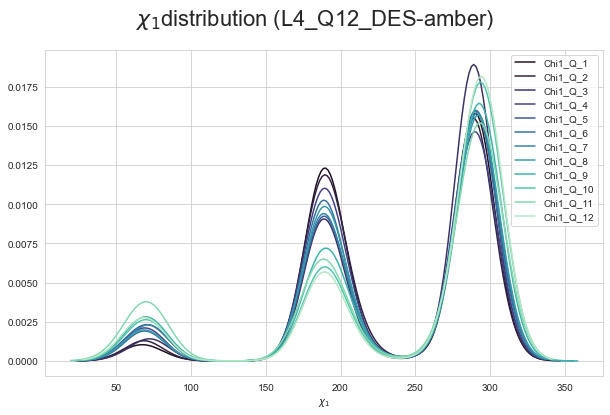

In [36]:
plt.figure(figsize=(10,6))
sns.set_style('whitegrid')
plt.suptitle(''r'$\chi_1$' 'distribution (L4_Q12_DES-amber)', fontsize=22)
my_colors = sns.color_palette('mako',n_colors=12)

chis1 = md.compute_chi1(t)[1]
chi1_1 = np.rad2deg(np.where(chis1[:,8]<0,chis1[:,8]+2*np.pi,chis1[:,8] ))
print(chi1_1)

chi1_12 = np.rad2deg(np.where(chis1[:,19]<0,chis1[:,19]+2*np.pi,chis1[:,19] ))

for i in range(12):
    chi1 = np.rad2deg(np.where(chis1[:,i+8]<0,chis1[:,i+8]+2*np.pi,chis1[:,i+8] ))
    pdf_c1 = gaussian_kde(chi1)
    x_c1 = np.linspace(min(chi1), max(chi1), 200)
    y_c1 = pdf_c1(x_c1)
    plt.plot(x_c1, y_c1, label="Chi1_Q_%s"%str(i+1),color=my_colors[i])
    

plt.legend(loc='best')
plt.xlabel(r'$\chi_1$');


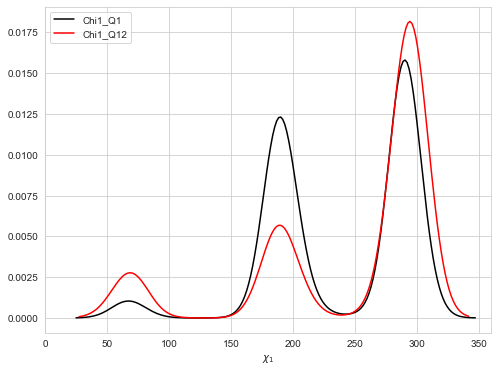

In [37]:
plt.figure(figsize=(8,6))
pdf_c1 = gaussian_kde(chi1_1)
x_c1 = np.linspace(min(chi1_1), max(chi1_1), 200)
y_c1 = pdf_c1(x_c1)
plt.plot(x_c1, y_c1, label="Chi1_Q1" ,color='k')

pdf_c1b= gaussian_kde(chi1_12)
x_c1b= np.linspace(min(chi1_12), max(chi1_12), 200)
y_c1b= pdf_c1b(x_c1b)
plt.plot(x_c1b, y_c1b, label="Chi1_Q12",color='r')

plt.xlabel(r'$\chi_1$');
plt.xlim(0,360)
plt.legend(loc="best")


(20001, 21)

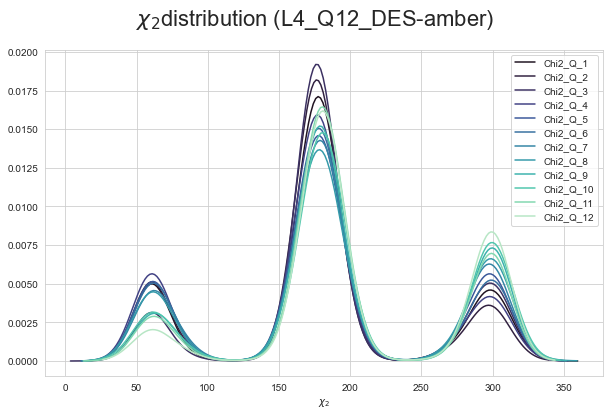

In [38]:
plt.figure(figsize=(10,6))
plt.suptitle(''r'$\chi_2$' 'distribution (L4_Q12_DES-amber)', fontsize=22)
chis2 = md.compute_chi2(t)[1]

chi2_1 = np.rad2deg(np.where(chis2[:,7]<0,chis2[:,7]+2*np.pi,chis2[:,7] ))

chi2_12 = np.rad2deg(np.where(chis2[:,18]<0,chis2[:,18]+2*np.pi,chis2[:,18] ))


for i in range(12):
    chi2 = np.rad2deg(np.where(chis2[:,i+7]<0,chis2[:,i+7]+2*np.pi,chis2[:,i+7] ))
    pdf_c2 = gaussian_kde(chi2)
    x_c2 = np.linspace(min(chi2), max(chi2), 200)
    y_c2 = pdf_c2(x_c2)
    plt.plot(x_c2, y_c2, label="Chi2_Q_%s"%str(i+1),color=my_colors[i])

plt.legend(loc='best')
plt.xlabel(r'$\chi_2$');
chis2.shape

(20001, 16)


(20001, 16)

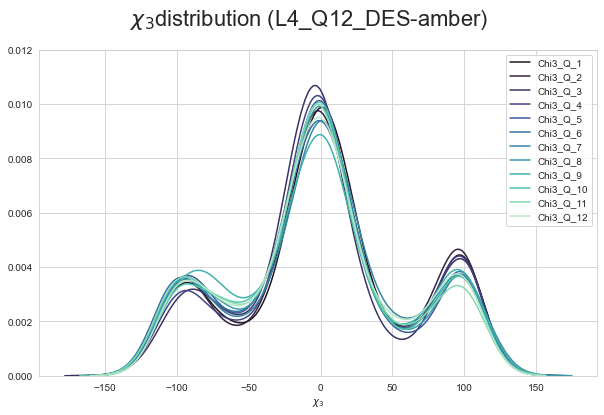

In [39]:
plt.figure(figsize=(10,6))
plt.suptitle(''r'$\chi_3$' 'distribution (L4_Q12_DES-amber)', fontsize=22)
chis3 = md.compute_chi3(t)[1]
print (chis3.shape)
chi3_1 = np.rad2deg(chis3[:,2])
chi3_12 = np.rad2deg(chis3[:,13])

for i in range(12):
    chi3 = np.rad2deg(chis3[:,i+2])
    pdf_c3 = gaussian_kde(chi3)
    x_c3 = np.linspace(min(chi3), max(chi3), 200)
    y_c3 = pdf_c3(x_c3)
    plt.plot(x_c3, y_c3, label="Chi3_Q_%s"%str(i+1),color=my_colors[i])

plt.legend(loc='best')
plt.ylim(0,0.012)
plt.xlabel(r'$\chi_3$');
chis3.shape

### Dihedrals Calculations for different conditions

Now we are interesting in how the rotamers vary depending on whether the residue is helical or not/is forming a hydrogen bond or not

In [40]:
# Compute the chi angles when the residues from 8 to 11 (9 to 12 starting in 0) are helical  
chis1_helix = md.compute_chi1(t_helix)[1]
chi1_1_helix = np.rad2deg(np.where(chis1_helix[:,8]<0,chis1_helix[:,8]+2*np.pi,chis1_helix[:,8] ))

chis2_helix = md.compute_chi2(t_helix)[1]
chi2_1_helix = np.rad2deg(np.where(chis2_helix[:,7]<0,chis2_helix[:,7]+2*np.pi,chis2_helix[:,7] ))

chis3_helix = md.compute_chi3(t_helix)[1]
chi3_1_helix = np.rad2deg(chis3_helix[:,2])
print(chi3_1_helix)

[106.2134     63.770454  125.89142   ...  -3.066271  -16.24318
   1.7469603]


In [41]:
# Compute the chi angles when the L1-Q1 sc-mc hydrogen bond is happening 
chis1_helix_hbond = md.compute_chi1(t_helix_hbond)[1]
chi1_1_helix_hbond = np.rad2deg(np.where(chis1_helix_hbond[:,8]<0,chis1_helix_hbond[:,8]+2*np.pi,chis1_helix_hbond[:,8] ))

chis2_helix_hbond = md.compute_chi2(t_helix_hbond)[1]
chi2_1_helix_hbond = np.rad2deg(np.where(chis2_helix_hbond[:,7]<0,chis2_helix_hbond[:,7]+2*np.pi,chis2_helix_hbond[:,7] ))

chis3_helix_hbond = md.compute_chi3(t_helix_hbond)[1]
chi3_1_helix_hbond = np.rad2deg(chis3_helix_hbond[:,2])

In [42]:
# Compute the chi angles when the residues from 18 to 21 (17 to 20 starting in 0) are not helical  (coil)
chis1_coil = md.compute_chi1(t_coil)[1]
chi1_12_coil = np.rad2deg(np.where(chis1_coil[:,19]<0,chis1_coil[:,19]+2*np.pi,chis1_coil[:,19] ))

chis2_coil = md.compute_chi2(t_coil)[1]
chi2_12_coil = np.rad2deg(np.where(chis2_coil[:,18]<0,chis2_coil[:,18]+2*np.pi,chis2_coil[:,18] ))

chis3_coil = md.compute_chi3(t_coil)[1]
chi3_12_coil = np.rad2deg(chis3_coil[:,13])

### Visualization of dihedral angles of helical Q1 vs H-bond forming Q1

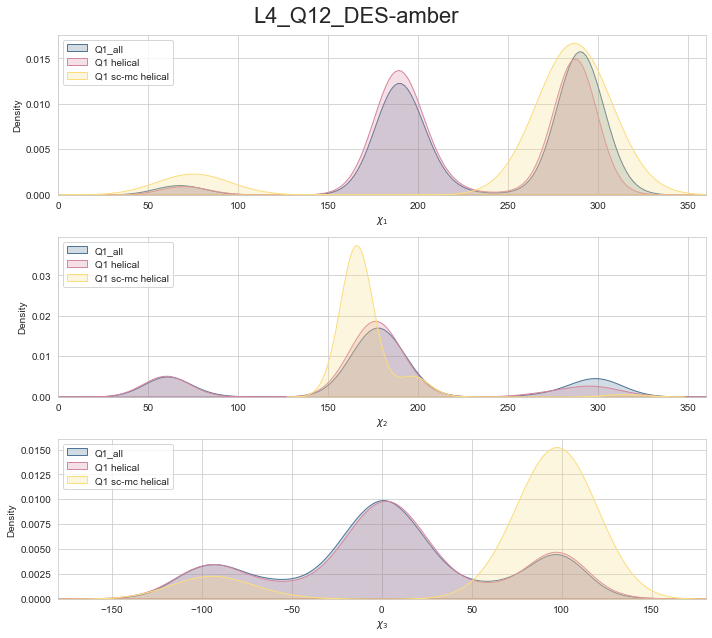

In [43]:
plt.figure(figsize=(10,9))
plt.suptitle('L4_Q12_DES-amber', fontsize=22)
plt.subplot(311)
sns.kdeplot(chi1_1,shade=True, label="Q1_all", color='#4e7496')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
sns.kdeplot(chi1_1_helix,shade=True, label="Q1 helical", color='#d5869d') 
sns.kdeplot(chi1_1_helix_hbond,shade=True, label="Q1 sc-mc helical", color='#fbdd7e') 
plt.legend(loc="upper left")
plt.xlabel(r'$\chi_1$');
plt.xlim(0,360)

plt.subplot(312)
sns.kdeplot(chi2_1,shade=True,label="Q1_all", color='#4e7496') 
sns.kdeplot(chi2_1_helix,shade=True, label="Q1 helical", color='#d5869d') 
sns.kdeplot(chi2_1_helix_hbond,shade=True, label="Q1 sc-mc helical", color='#fbdd7e') 
plt.legend(loc="upper left")
plt.xlabel(r'$\chi_2$');
plt.xlim(0,360)

plt.subplot(313)
sns.kdeplot(chi3_1,shade=True,label="Q1_all", color='#4e7496') 
sns.kdeplot(chi3_1_helix,shade=True, label="Q1 helical", color='#d5869d') 
sns.kdeplot(chi3_1_helix_hbond,shade=True,label="Q1 sc-mc helical", color='#fbdd7e') 
plt.legend(loc="upper left")
plt.xlabel(r'$\chi_3$');
plt.xlim(-180,180)

plt.tight_layout()

# plt.savefig('chis.png', dpi=200)


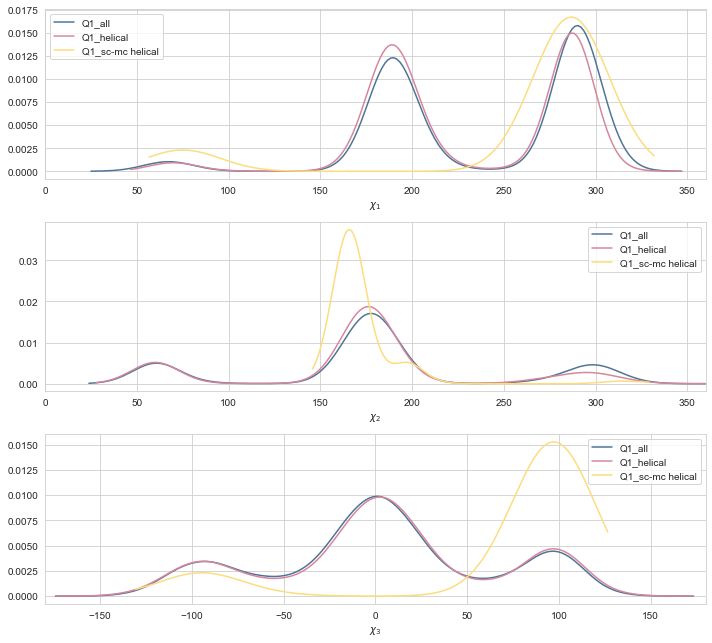

In [44]:
plt.figure(figsize=(10,9))

plt.subplot(311)
pdf_c1 = gaussian_kde(chi1_1)
x_c1 = np.linspace(min(chi1_1), max(chi1_1), 200)
y_c1 = pdf_c1(x_c1)
plt.plot(x_c1, y_c1, label="Q1_all", color='#4e7496')

pdf_c1b = gaussian_kde(chi1_1_helix)
x_c1b = np.linspace(min(chi1_1_helix), max(chi1_1_helix), 200)
y_c1b = pdf_c1b(x_c1b)
plt.plot(x_c1b, y_c1b,label="Q1_helical", color='#d5869d')

pdf_c1c= gaussian_kde(chi1_1_helix_hbond)
x_c1c= np.linspace(min(chi1_1_helix_hbond), max(chi1_1_helix_hbond), 200)
y_c1c= pdf_c1c(x_c1c)
plt.plot(x_c1c, y_c1c, label="Q1_sc-mc helical", color='#fbdd7e')
plt.legend()

plt.xlabel(r'$\chi_1$');
plt.xlim(0,360)


plt.subplot(312)
pdf_c2= gaussian_kde(chi2_1)
x_c2 = np.linspace(min(chi2_1), max(chi2_1), 200)
y_c2 = pdf_c2(x_c2)
plt.plot(x_c2, y_c2, label="Q1_all", color='#4e7496')

pdf_c2b = gaussian_kde(chi2_1_helix)
x_c2b = np.linspace(min(chi2_1_helix), max(chi2_1_helix), 200)
y_c2b = pdf_c2b(x_c2b)
plt.plot(x_c2b, y_c2b,label="Q1_helical", color='#d5869d')

pdf_c2c= gaussian_kde(chi2_1_helix_hbond)
x_c2c= np.linspace(min(chi2_1_helix_hbond), max(chi2_1_helix_hbond), 200)
y_c2c= pdf_c2c(x_c2c)
plt.plot(x_c2c, y_c2c, label="Q1_sc-mc helical", color='#fbdd7e')
plt.legend()

plt.xlabel(r'$\chi_2$');
plt.xlim(0,360)


plt.subplot(313)
pdf_c3= gaussian_kde(chi3_1)
x_c3 = np.linspace(min(chi3_1), max(chi3_1), 200)
y_c3 = pdf_c3(x_c3)
plt.plot(x_c3, y_c3, label="Q1_all", color='#4e7496')

pdf_c3b = gaussian_kde(chi3_1_helix)
x_c3b = np.linspace(min(chi3_1_helix), max(chi3_1_helix), 200)
y_c3b = pdf_c3b(x_c3b)
plt.plot(x_c3b, y_c3b,label="Q1_helical", color='#d5869d')

pdf_c3c= gaussian_kde(chi3_1_helix_hbond)
x_c3c= np.linspace(min(chi3_1_helix_hbond), max(chi3_1_helix_hbond), 200)
y_c3c= pdf_c3c(x_c3c)
plt.plot(x_c3c, y_c3c, label="Q1_sc-mc helical", color='#fbdd7e')
plt.legend()

plt.xlabel(r'$\chi_3$');
plt.xlim(-180,180)

plt.tight_layout()
# plt.savefig('chis.png', dpi=200)

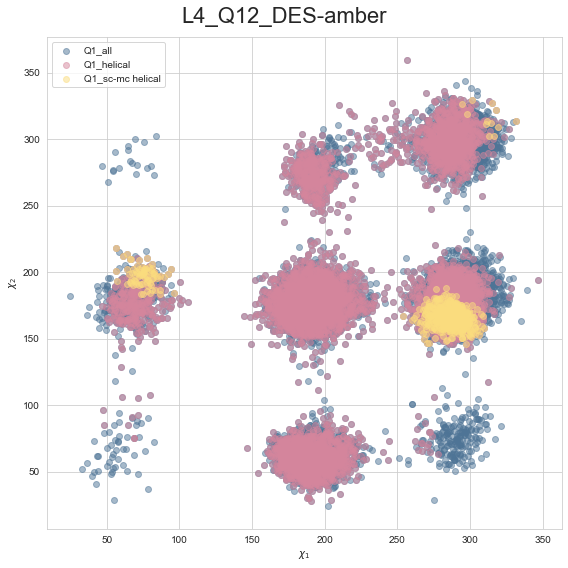

In [45]:
plt.figure(figsize=(8,8))
plt.suptitle('L4_Q12_DES-amber', fontsize=22)
plt.scatter(chi1_1,chi2_1, marker='o', color='#4e7496', label="Q1_all",alpha=0.5) 
plt.scatter(chi1_1_helix, chi2_1_helix, color='#d5869d', marker='o', label="Q1_helical",alpha=0.5) 
plt.scatter(chi1_1_helix_hbond, chi2_1_helix_hbond,color='#fbdd7e', marker='o', label="Q1_sc-mc helical",alpha=0.5)
plt.xlabel(r'$\chi_1$');
plt.ylabel(r'$\chi_2$');
plt.legend(loc='best')
plt.tight_layout()


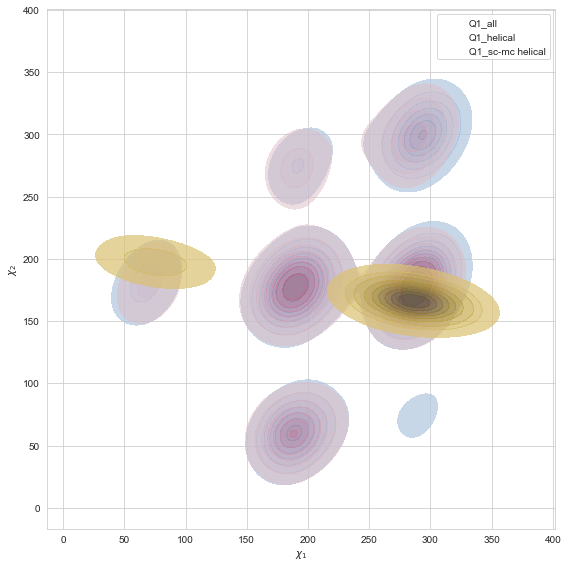

In [27]:
plt.figure(figsize=(8,8))
sns.kdeplot(x=chi1_1,y=chi2_1, color='#4e7496', shade='fill', label="Q1_all",alpha=0.7) 
sns.kdeplot(x=chi1_1_helix, y=chi2_1_helix, color='#d5869d',  shade='fill', label="Q1_helical",alpha=0.5) 
sns.kdeplot(x=chi1_1_helix_hbond, y=chi2_1_helix_hbond, color='#fbdd7e', shade='fill', label="Q1_sc-mc helical",alpha=0.7 )
plt.xlabel(r'$\chi_1$');
plt.ylabel(r'$\chi_2$');
plt.legend(loc='best')
plt.tight_layout()


### Visualization of dihedral angles of helical Q1 vs coil Q12

We are interested in studying the different rotamers that allow or are responsible for the formation of the sc-mc hydrogen bond in polyQ peptides. To do that, it would be a good approach to observe the differences between the helical glutamine  residues (forming and not forming an hydrogen bond) and those that have adopted a disorderly form (coil)

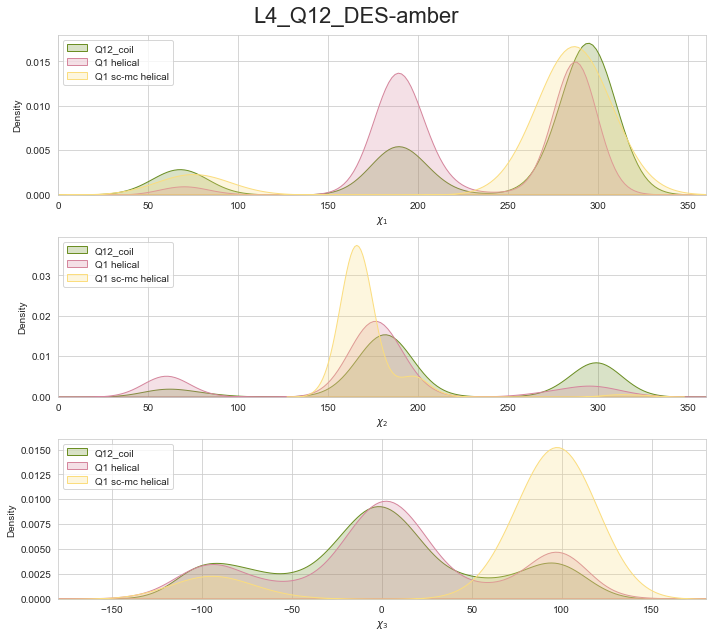

In [46]:
plt.figure(figsize=(10,9))
plt.suptitle('L4_Q12_DES-amber', fontsize=22)
plt.subplot(311)
sns.kdeplot(chi1_12_coil,shade=True, label="Q12_coil", color='olivedrab')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
sns.kdeplot(chi1_1_helix,shade=True, label="Q1 helical", color='#d5869d') 
sns.kdeplot(chi1_1_helix_hbond,shade=True, label="Q1 sc-mc helical", color='#fbdd7e') 
plt.legend(loc="upper left")
plt.xlabel(r'$\chi_1$');
plt.xlim(0,360)

plt.subplot(312)
sns.kdeplot(chi2_12_coil,shade=True,label="Q12_coil", color='olivedrab') 
sns.kdeplot(chi2_1_helix,shade=True, label="Q1 helical", color='#d5869d') 
sns.kdeplot(chi2_1_helix_hbond,shade=True, label="Q1 sc-mc helical", color='#fbdd7e') 
plt.legend(loc="upper left")
plt.xlabel(r'$\chi_2$');
plt.xlim(0,360)

plt.subplot(313)
sns.kdeplot(chi3_12_coil,shade=True,label="Q12_coil", color='olivedrab') 
sns.kdeplot(chi3_1_helix,shade=True, label="Q1 helical", color='#d5869d') 
sns.kdeplot(chi3_1_helix_hbond,shade=True,label="Q1 sc-mc helical", color='#fbdd7e') 
plt.legend(loc="upper left")
plt.xlabel(r'$\chi_3$');
plt.xlim(-180,180)

plt.tight_layout()


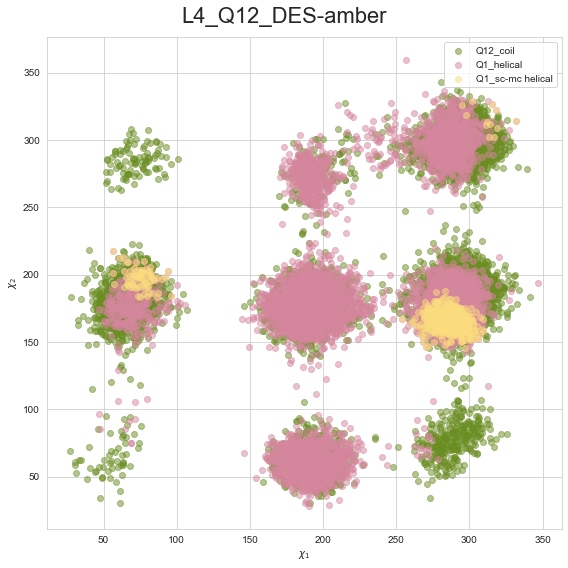

In [47]:
plt.figure(figsize=(8,8))
plt.suptitle('L4_Q12_DES-amber', fontsize=22)
plt.scatter(chi1_12_coil,chi2_12_coil, marker='o', color='olivedrab', label="Q12_coil", alpha=0.5) 
plt.scatter(chi1_1_helix, chi2_1_helix, color='#d5869d', marker='o', label="Q1_helical",alpha=0.5) 
plt.scatter(chi1_1_helix_hbond, chi2_1_helix_hbond,color='#fbdd7e', marker='o', label="Q1_sc-mc helical",alpha=0.5 )
plt.xlabel(r'$\chi_1$');
plt.ylabel(r'$\chi_2$');
plt.legend(loc='best')
plt.tight_layout()

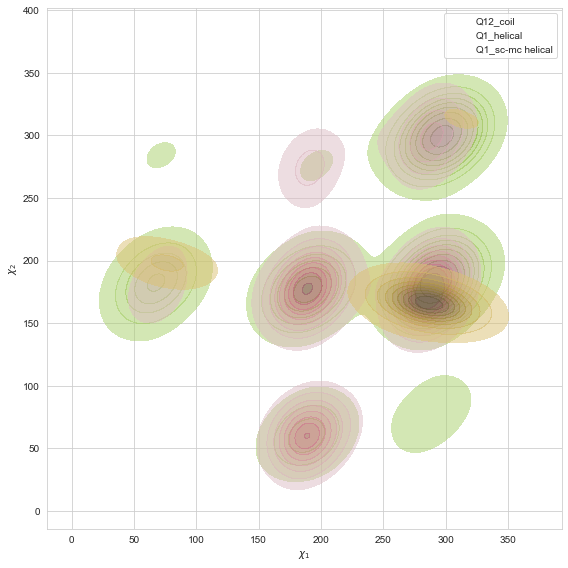

In [82]:
plt.figure(figsize=(8,8))
sns.kdeplot(x=chi1_12_coil,y=chi2_12_coil, color='olivedrab', shade='fill', label="Q12_coil",alpha=0.5) 
sns.kdeplot(x=chi1_1_helix, y=chi2_1_helix, color='#d5869d',  shade='fill', label="Q1_helical",alpha=0.5) 
sns.kdeplot(x=chi1_1_helix_hbond, y=chi2_1_helix_hbond, color='#fbdd7e', shade='fill', label="Q1_sc-mc helical",alpha=0.5)
plt.xlabel(r'$\chi_1$');
plt.ylabel(r'$\chi_2$');
plt.legend()
plt.tight_layout()


In [48]:
import collections

#Creating a disctionary where the keys are the different rotamer annotations and the values are the number of times each
#rotamer appears in the trajectory

# DICTIONARY FOR HELICAL Q1

i = 0
j = 0
Q1_helix_rotamers = []

for i,j in zip(chi1_1_helix,chi2_1_helix):
    if i <=120 and j<=120:
        rot = "g+g+"
        Q1_helix_rotamers.append(rot)
    elif i<= 120 and (j>120 and j<=240):
        rot = "g+t"
        Q1_helix_rotamers.append(rot)
    elif i<= 120 and (j>240 and j<=360):
        rot = "g+g-"
        Q1_helix_rotamers.append(rot)
    elif (i>120 and i<=240) and j<=120:
        rot = "tg+"
        Q1_helix_rotamers.append(rot)
    elif (i>120 and i<=240) and (j>120 and j<=240):
        rot = "tt"
        Q1_helix_rotamers.append(rot)
    elif (i>120 and i<=240) and (j>240 and j<=360):
        rot = "tg-"
        Q1_helix_rotamers.append(rot)
    elif (i>240 and i<=360) and (j<=120):
        rot = "g-g+"
        Q1_helix_rotamers.append(rot)
    elif (i>240 and i<=360) and (j>120 and j<=240):
        rot = "g-t"
        Q1_helix_rotamers.append(rot)
    else:
        rot = "g-g-"
        Q1_helix_rotamers.append(rot)

df_helix = pd.DataFrame(list(zip(chi1_1_helix,chi2_1_helix,Q1_helix_rotamers,chi3_1_helix)), 
          columns=['chi1_1H','chi2_1H','r1r2RotamersPopulation','chi3_1H'])
print (df_helix)


Q1_helix_RotCount = collections.Counter(Q1_helix_rotamers)
Q1_helix_RotCount['g+g-'] = 0
Q1_helix_RotDict = dict(Q1_helix_RotCount)
Q1_helix_RotSort = dict(sorted(Q1_helix_RotDict.items()))

print (Q1_helix_RotSort)


          chi1_1H     chi2_1H r1r2RotamersPopulation     chi3_1H
0      183.387619  174.958282                     tt  106.213402
1      191.017456  170.135162                     tt   63.770454
2      205.551682  172.838089                     tt  125.891418
3      214.664764  179.349915                     tt   96.237976
4      233.087738  181.805008                     tt  105.350105
...           ...         ...                    ...         ...
11434  309.699921  180.522766                    g-t   -1.733205
11435  302.003845  176.506180                    g-t   11.456688
11436  288.108368  165.509537                    g-t   -3.066271
11437  274.914124  163.749084                    g-t  -16.243179
11438  282.729828  183.451447                    g-t    1.746960

[11439 rows x 4 columns]
{'g+g+': 10, 'g+g-': 0, 'g+t': 351, 'g-g+': 20, 'g-g-': 1092, 'g-t': 4274, 'tg+': 1932, 'tg-': 413, 'tt': 3347}


In [49]:
# DICTIONARY FOR COIL Q12

k = 0
l = 0
Q12_coil_rotamers = []

for k,l in zip(chi1_12_coil,chi2_12_coil):
    if k <=120 and l<=120:
        rot2 = "g+g+"
        Q12_coil_rotamers.append(rot2)
    elif k<= 120 and (l>120 and l<=240):
        rot2 = "g+t"
        Q12_coil_rotamers.append(rot2)
    elif k<= 120 and (l>240 and l<=360):
        rot2 = "g+g-"
        Q12_coil_rotamers.append(rot2)
    elif (k>120 and k<=240) and l<=120:
        rot2 = "tg+"
        Q12_coil_rotamers.append(rot2)
    elif (k>120 and k<=240) and (l>120 and l<=240):
        rot2 = "tt"
        Q12_coil_rotamers.append(rot2)
    elif (k>120 and k<=240) and (l>240 and l<=360):
        rot2 = "tg-"
        Q12_coil_rotamers.append(rot2)
    elif (k>240 and k<=360) and (l<=120):
        rot2 = "g-g+"
        Q12_coil_rotamers.append(rot2)
    elif (k>240 and k<=360) and (l>120 and l<=240):
        rot2 = "g-t"
        Q12_coil_rotamers.append(rot2)
    else:
        rot2 = "g-g-"
        Q12_coil_rotamers.append(rot2)

df_coil = pd.DataFrame(list(zip(chi1_12_coil,chi2_12_coil,Q12_coil_rotamers,chi3_12_coil)), 
                  columns=['chi1_12C','chi2_12C','r1r2RotamersPopulation','chi3_12C'])
print (df_coil)

Q12_coil_RotCount = collections.Counter(Q12_coil_rotamers)
Q12_coil_RotDict = dict(Q12_coil_RotCount)
Q12_coil_RotSort = dict(sorted(Q12_coil_RotDict.items()))

print (Q12_coil_RotSort)



         chi1_12C    chi2_12C r1r2RotamersPopulation   chi3_12C
0      272.009186  282.554077                   g-g-  22.432007
1      287.801514  295.745850                   g-g-  13.395479
2      307.928589  294.303314                   g-g-  19.051069
3      292.832153  281.078064                   g-g-  78.319946
4       66.090691  191.727921                    g+t -29.312803
...           ...         ...                    ...        ...
14050  200.257492   55.546825                    tg+   9.061208
14051  187.650513   78.561760                    tg+ -12.901694
14052  290.710907   80.343262                   g-g+ -12.557330
14053  276.384308   72.930557                   g-g+  25.110012
14054  282.249420   80.034920                   g-g+   5.593614

[14055 rows x 4 columns]
{'g+g+': 56, 'g+g-': 92, 'g+t': 1430, 'g-g+': 287, 'g-g-': 4212, 'g-t': 4930, 'tg+': 802, 'tg-': 114, 'tt': 2132}


In [50]:
# DICTIONARY FOR Hydrogen Bond Forming Q1

e = 0
f = 0
Q1_helix_hbond_rotamers = []

for e,f in zip(chi1_1_helix_hbond,chi2_1_helix_hbond):
    if e<=120 and f<=120:
        rot3 = "g+g+"
        Q1_helix_hbond_rotamers.append(rot3)
    elif e<= 120 and (f>120 and f<=240):
        rot3 = "g+t"
        Q1_helix_hbond_rotamers.append(rot3)
    elif e<= 120 and (f>240 and f<=360):
        rot3 = "g+g-"
        Q1_helix_hbond_rotamers.append(rot3)
    elif (e>120 and e<=240) and f<=120:
        rot3 = "tg+"
        Q1_helix_hbond_rotamers.append(rot3)
    elif (e>120 and e<=240) and (f>120 and f<=240):
        rot3 = "tt"
        Q1_helix_hbond_rotamers.append(rot3)
    elif (e>120 and e<=240) and (f>240 and f<=360):
        rot3 = "tg-"
        Q1_helix_hbond_rotamers.append(rot3)
    elif (e>240 and e<=360) and (f<=120):
        rot3 = "g-g+"
        Q1_helix_hbond_rotamers.append(rot3)
    elif (e>240 and e<=360) and (f>120 and f<=240):
        rot3 = "g-t"
        Q1_helix_hbond_rotamers.append(rot3)
    else:
        rot3 = "g-g-"
        Q1_helix_hbond_rotamers.append(rot3)

# Dataframe 
df_hbond = pd.DataFrame(list(zip(chi1_1_helix_hbond,chi2_1_helix_hbond,Q1_helix_hbond_rotamers,chi3_1_helix_hbond)), 
                  columns=['chi1_1_HH','chi2_1_HH','r1r2RotamersPopulation','chi3_1_HH'])
print (df_hbond)


Q1_helix_hbond_RotCount = collections.Counter(Q1_helix_hbond_rotamers)
print (Q1_helix_hbond_RotCount)

# This should be modified and get it into  a conditional loop that would be able to check if the dictionary presents 
#all the nine different rotamers population and if not, then add all they are missing
Q1_helix_hbond_RotCount['g+g+'] = 0
Q1_helix_hbond_RotCount['g+g-'] = 0
Q1_helix_hbond_RotCount['g-g+'] = 0
Q1_helix_hbond_RotCount['tt'] = 0
Q1_helix_hbond_RotCount['tg-'] = 0
Q1_helix_hbond_RotCount['tg+'] = 0
print("Updated Dict is: ", Q1_helix_hbond_RotCount)

Q1_helix_hbond_RotDict = dict(Q1_helix_hbond_RotCount)
Q1_helix_hbond_RotSort = dict(sorted(Q1_helix_hbond_RotDict.items()))

print(Q1_helix_hbond_RotSort)




      chi1_1_HH   chi2_1_HH r1r2RotamersPopulation   chi3_1_HH
0    281.837036  157.489105                    g-t   67.055473
1    277.927124  166.764420                    g-t   91.266983
2    289.266815  173.008301                    g-t   93.605995
3    280.144714  157.159180                    g-t   90.145920
4    289.482208  173.417313                    g-t   97.311081
..          ...         ...                    ...         ...
652  280.361786  162.538147                    g-t   93.228455
653  284.592377  163.386337                    g-t   59.814640
654  259.891479  163.848724                    g-t  107.893700
655  292.444214  165.268250                    g-t   63.895985
656  269.387817  153.822083                    g-t  105.104370

[657 rows x 4 columns]
Counter({'g-t': 567, 'g+t': 78, 'g-g-': 12})
Updated Dict is:  Counter({'g-t': 567, 'g+t': 78, 'g-g-': 12, 'g+g+': 0, 'g+g-': 0, 'g-g+': 0, 'tt': 0, 'tg-': 0, 'tg+': 0})
{'g+g+': 0, 'g+g-': 0, 'g+t': 78, 'g-g+': 0, 'g-g-

Text(0, 0.5, 'Total Number')

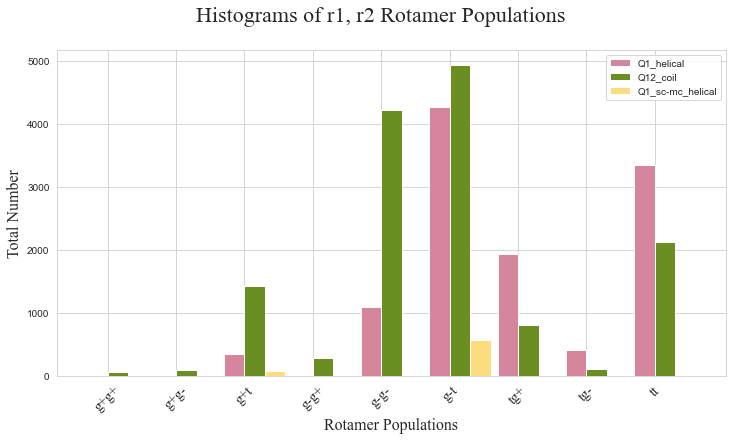

In [51]:
fig = plt.figure(figsize=(12,6)) 
sns.set_style('whitegrid')
ind = np.arange(9)
width = 0.30  
categories = ['g+g+','g+g-','g+t','g-g+','g-g-','g-t','tg+','tg-','tt']
csfont = {'fontname':'Times New Roman'}

plt.bar(ind, Q1_helix_RotSort.values(), width, label="Q1_helical", color="#d5869d", align="edge")
plt.bar(ind+width, Q12_coil_RotSort.values(), width, label="Q12_coil", color="olivedrab", align="edge")
plt.bar(ind+2*width, Q1_helix_hbond_RotSort.values(), width, label="Q1_sc-mc_helical", color="#fbdd7e", align="edge")
plt.xticks(ind + width, categories, fontsize=14, rotation=45, **csfont)
plt.legend(loc="best")
fig.suptitle('Histograms of r1, r2 Rotamer Populations', fontsize=22, **csfont)
plt.xlabel('Rotamer Populations', fontsize=16, **csfont)
plt.ylabel('Total Number', fontsize=16, **csfont)


Now, it would be a good approach to study the total pertentaje of each r1r2 rotamers (depending on the secondary structure it addopts) instead of the total number. 

In [52]:
# Function to modify each value of the dictionary
def mutate_dict(f,d):
    for k, v in d.items():
        d[k] = f(v)

# Helical Q1 
values_Q1H = Q1_helix_RotSort.values()
print(values_Q1H)
factor1 = 100/sum(values_Q1H)
print(factor1)

mutate_dict(lambda x: x*factor1, Q1_helix_RotSort)
print (Q1_helix_RotSort)
    

#Coil Q12 
values_Q12C = Q12_coil_RotSort.values()
print(values_Q12C)
factor2 = 100/sum(values_Q12C)
print(factor2)

mutate_dict(lambda x: x*factor2, Q12_coil_RotSort)
print (Q12_coil_RotSort)


# Q1 forming a sc-mc hydrogen bond with L1
values_Q1HH = Q1_helix_hbond_RotSort.values()
print(values_Q1HH)
factor3 = 100/sum(values_Q1HH)
print(factor3)

mutate_dict(lambda x: x*factor3, Q1_helix_hbond_RotSort)
print (Q1_helix_hbond_RotSort)

dict_values([10, 0, 351, 20, 1092, 4274, 1932, 413, 3347])
0.008742022904100009
{'g+g+': 0.08742022904100008, 'g+g-': 0.0, 'g+t': 3.068450039339103, 'g-g+': 0.17484045808200016, 'g-g-': 9.54628901127721, 'g-t': 37.36340589212344, 'tg+': 16.889588250721218, 'tg-': 3.610455459393304, 'tt': 29.25955066002273}
dict_values([56, 92, 1430, 287, 4212, 4930, 802, 114, 2132])
0.007114905727499111
{'g+g+': 0.39843472073995023, 'g+g-': 0.6545713269299182, 'g+t': 10.174315190323728, 'g-g+': 2.041977943792245, 'g-g-': 29.967982924226256, 'g-t': 35.07648523657062, 'tg+': 5.706154393454287, 'tg-': 0.8110992529348986, 'tt': 15.168979011028105}
dict_values([0, 0, 78, 0, 12, 567, 0, 0, 0])
0.15220700152207
{'g+g+': 0.0, 'g+g-': 0.0, 'g+t': 11.87214611872146, 'g-g+': 0.0, 'g-g-': 1.82648401826484, 'g-t': 86.30136986301369, 'tg+': 0.0, 'tg-': 0.0, 'tt': 0.0}


Text(0, 0.5, 'Percent of total')

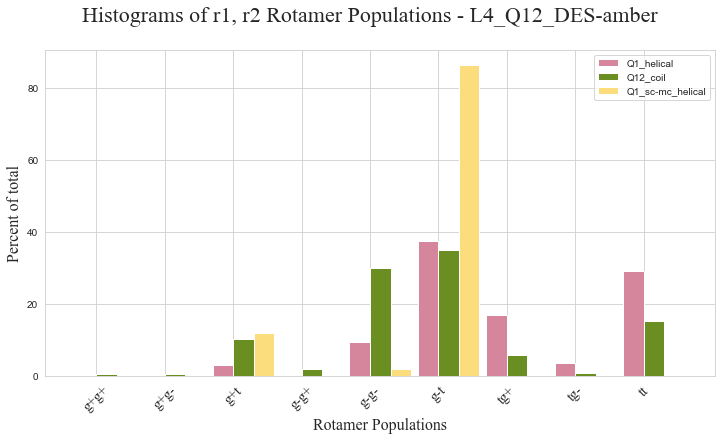

In [54]:
fig = plt.figure(figsize=(12,6)) 
sns.set_style('whitegrid')
ind = np.arange(9)
width = 0.30  
categories = ['g+g+','g+g-','g+t','g-g+','g-g-','g-t','tg+','tg-','tt']
csfont = {'fontname':'Times New Roman'}

plt.bar(ind, Q1_helix_RotSort.values(), width, label="Q1_helical", color="#d5869d", align="edge")
plt.bar(ind+width, Q12_coil_RotSort.values(), width, label="Q12_coil", color="olivedrab", align="edge")
plt.bar(ind+2*width, Q1_helix_hbond_RotSort.values(), width, label="Q1_sc-mc_helical", color="#fbdd7e", align="edge")
plt.xticks(ind + width, categories, fontsize=14, rotation=45, **csfont)
plt.legend(loc="best")
fig.suptitle('Histograms of r1, r2 Rotamer Populations - L4_Q12_DES-amber', fontsize=22, **csfont)
plt.xlabel('Rotamer Populations', fontsize=16, **csfont)
plt.ylabel('Percent of total', fontsize=16, **csfont)


### r3 Kernel Density Analysis

#### The backbone-independent distribution of nonrotameric χ3 of Gln for each of its (χ1, χ2) rotamers. 

Nonrotameric χ3 distributions for Gln are dependent on both the χ1 and χ2 rotamers. The distributions of the nonrotameric degrees of freedom are very broad and asymmetric and cannot be modeled with a rotameric model (Shapovalov & Dunbrack Jr, 2011)

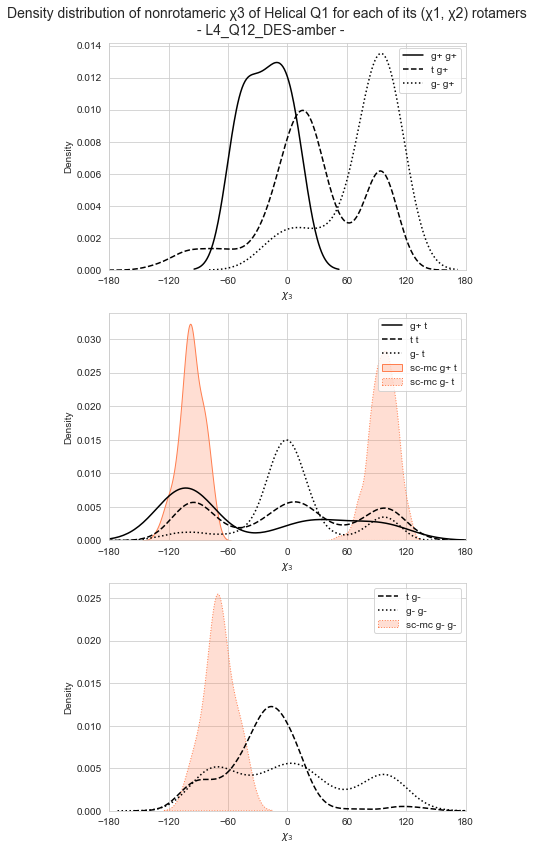

In [58]:
# We are going to use the created dataframes for each Gln condition

# HELICAL Q1 --> dataframe = df_helix

plt.figure(figsize=(6,12)) 
sns.set_style('whitegrid')
plt.suptitle('Density distribution of nonrotameric χ3 of Helical Q1 for each of its (χ1, χ2) rotamers \n - L4_Q12_DES-amber -', fontsize=14)
angles = [-180,-120,-60,0,60,120,180]

plt.subplot(311)
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "g+g+"'), x="chi3_1H", linestyle="-", label="g+ g+", color="k")
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "tg+"'), x="chi3_1H", linestyle="--", label="t g+",color="k")
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "g-g+"'), x="chi3_1H", linestyle=":", label="g- g+",color="k")
plt.legend(loc="best")
plt.xlabel(r'$\chi_3$')
plt.xlim(-180,180)
plt.xticks(angles)

plt.subplot(312)
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "g+t"'), x="chi3_1H", linestyle="-", label="g+ t", color="k")
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g+t"'), x="chi3_1_HH", linestyle="-", label="sc-mc g+ t", color="coral", shade=True)
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "tt"'), x="chi3_1H", linestyle="--", label="t t",color="k")
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "g-t"'), x="chi3_1H", linestyle=":", label="g- t",color="k")
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g-t"'), x="chi3_1_HH", linestyle=":", label="sc-mc g- t",color="coral", shade=True)
plt.legend(loc="best")
plt.xlabel(r'$\chi_3$')
plt.xlim(-180,180)
plt.xticks(angles)

plt.subplot(313)
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "g+g-"'), x="chi3_1H", linestyle="-", label="g+ g-",color="k")
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "tg-"'), x="chi3_1H", linestyle="--", label="t g-",color="k")
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "g-g-"'), x="chi3_1H", linestyle=":", label="g- g-",color="k")
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g-g-"'), x="chi3_1_HH", linestyle=":", label="sc-mc g- g-",color="coral", shade=True)
plt.legend(loc="best")
plt.xlabel(r'$\chi_3$')
plt.xlim(-180,180)
plt.xticks(angles)

plt.tight_layout()

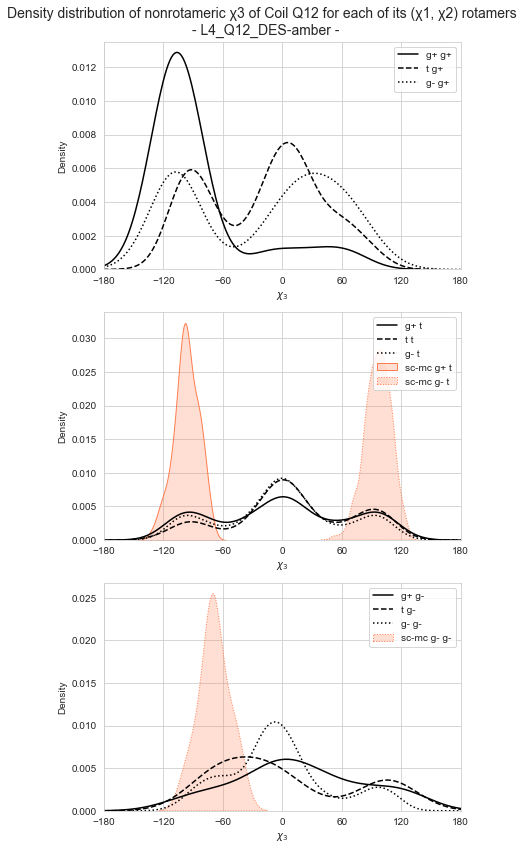

In [59]:
# We are going to use the created dataframes for each Gln condition

# COIL Q12 --> dataframe = df_coil

plt.figure(figsize=(6,12)) 
sns.set_style('whitegrid')
plt.suptitle('Density distribution of nonrotameric χ3 of Coil Q12 for each of its (χ1, χ2) rotamers \n - L4_Q12_DES-amber -', fontsize=14)
angles = [-180,-120,-60,0,60,120,180]

plt.subplot(311)
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "g+g+"'), x="chi3_12C", linestyle="-", label="g+ g+", color="k")
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "tg+"'), x="chi3_12C", linestyle="--", label="t g+",color="k")
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "g-g+"'), x="chi3_12C", linestyle=":", label="g- g+",color="k")
plt.legend(loc="best")
plt.xlabel(r'$\chi_3$')
plt.xlim(-180,180)
plt.xticks(angles)

plt.subplot(312)
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "g+t"'), x="chi3_12C", linestyle="-", label="g+ t", color="k")
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g+t"'), x="chi3_1_HH", linestyle="-", label="sc-mc g+ t", color="coral", shade=True)
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "tt"'), x="chi3_12C", linestyle="--", label="t t",color="k")
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "g-t"'), x="chi3_12C", linestyle=":", label="g- t",color="k")
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g-t"'), x="chi3_1_HH", linestyle=":", label="sc-mc g- t",color="coral", shade=True)
plt.legend(loc="best")
plt.xlabel(r'$\chi_3$')
plt.xlim(-180,180)
plt.xticks(angles)

plt.subplot(313)
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "g+g-"'), x="chi3_12C", linestyle="-", label="g+ g-",color="k")
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "tg-"'), x="chi3_12C", linestyle="--", label="t g-",color="k")
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "g-g-"'), x="chi3_12C", linestyle=":", label="g- g-",color="k")
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g-g-"'), x="chi3_1_HH", linestyle=":", label="sc-mc g- g-",color="coral",shade=True)
plt.legend(loc="best")
plt.xlabel(r'$\chi_3$')
plt.xlim(-180,180)
plt.xticks(angles)

plt.tight_layout()

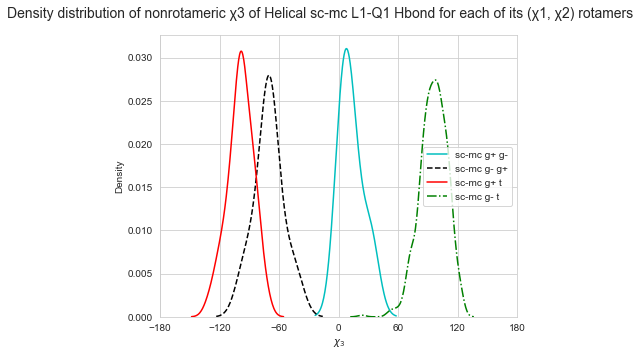

In [93]:
# HELICAL Q1 & L1-Q1 hbond --> dataframe = df_hbond

plt.figure(figsize=(6,5)) 
sns.set_style('whitegrid')
plt.suptitle('Density distribution of nonrotameric χ3 of Helical sc-mc L1-Q1 Hbond for each of its (χ1, χ2) rotamers', fontsize=14)
angles = [-180,-120,-60,0,60,120,180]
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "tg+"'), x="chi3_1_HH", linestyle="--", label="sc-mc g- g+",color="k")
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g+t"'), x="chi3_1_HH", linestyle="-", label="sc-mc g+ t", color="r")
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g-t"'), x="chi3_1_HH", linestyle="-.", label="sc-mc g- t",color="g")
plt.legend(loc="best")
plt.xlabel(r'$\chi_3$')
plt.xlim(-180,180)
plt.xticks(angles)


plt.tight_layout()